# GolemFlavor Inference

In this example, we will take the fake data generated in the `tutorial.ipynb` example and use it to make an inference the source flavor composition using Bayesian techniques.

In [1]:
from __future__ import absolute_import, division, print_function

from functools import partial

import numpy as np
import matplotlib.pyplot as plt

## Define Fake Data

We will generate some fake data using a multivariate Gaussian likelihood, as described in the `tutorial.ipynb` notebook. We set our injected source composition to the pion decay model $(1:2:0)_S$ and use the global neutrino data fit mixing matrix values to calculate the expected measured composition.

In [2]:
from golemflavor.fr import NUFIT_U
from golemflavor.fr import normalize_fr, u_to_fr

source_composition = normalize_fr((1, 0, 0))
measured_composition = u_to_fr(source_composition, NUFIT_U)

We also set the smearing, which represents detector related imperfections in our Gaussian likelihood:

In [3]:
smearing = 0.02

Then we define the `asimov_paramset` which contains `Params` objects for each of our measured quantities:

In [4]:
from golemflavor.fr import fr_to_angles
from golemflavor.enums import ParamTag
from golemflavor.param import Param, ParamSet

# Convert from flavor composition to flavor angles
measured_flavor_angles = fr_to_angles(measured_composition)

# Parameters can be tagged for later convenience
tag = ParamTag.BESTFIT

# Define the asimov `ParamSet`, with `Param` objects containing information such as name, value and ranges.
asimov_paramset = [
    Param(name='measured_angle1', value=measured_flavor_angles[0], ranges=[ 0., 1.], std=smearing, tag=tag, tex=r'\sin^4\phi_\oplus'),
    Param(name='measured_angle2', value=measured_flavor_angles[1], ranges=[-1., 1.], std=smearing, tag=tag, tex=r'\cos(2\psi_\oplus)')
]
asimov_paramset = ParamSet(asimov_paramset)

## Physics Model

The goal here is to make an inference of the source flavor composition from our fake data measurement. In order to do this, we need a model that links the two. Of course, in this case we will use the neutrino mixing model that we generated the fake data with, but it is worth mentioning that with real data we sometimes do not have this luxury. Model dependence is a heavily debated topic in physics. That isn't to say that having model dependence is a bad thing, indeed the best physicists are ones which do make model assumptions but can however justify their simplifications to the wider community.

As a reminder from `tutorial.ipynb`, the measured flavor composition can be written as a function of the source flavor composition and mixing matrix:

$$ \phi_{\alpha,\oplus}=\sum_{i,\beta} \mid{U_{\alpha i}}\mid^2\mid{U_{\beta i}}\mid^2\phi_{\beta,\text{S}} $$

So here we must sample over the source flavor compositions to see which agrees best with the data. However, we must also take into account that the values of the mixing matrix are perfect and have uncertainties of their own.

### Nuisance Parameters

Not all parameters of a model are of direct inferential interest, however they still need to be included as they may reduce the effect of systematic bias. These are called *nuisance parameters*. Here the mixing matrix parameters are examples of such nuisance parameters and we must include the effect of their uncertainties in our inference of the source flavor composition.

#### Anarchic Sampling

In the same way that flavor compositions cannot directly be sampled over, the mixing matrix values also cannot directly be sampled (it's also **extremely** inefficient to brute force sample values in a matrix such that the resulting matrix is unitary). As with any Bayesian inference, the prior distribution needs to be chosen carefully. Firstly we can rewrite the $3\times3$ unitary mixing matrix in terms of *mixing angles*. The following is the standard representation most commonly used:

$$
\begin{align}
  U=
  \begin{pmatrix}
    1    & 0       & 0      \\
    0    & c_{23}  & s_{23} \\
    0    & -s_{23} & c_{23} \\
  \end{pmatrix}
  \begin{pmatrix}
    c_{13}             & 0 & s_{13}e^{-i\delta} \\
    0                  & 1 & 0                  \\
    -s_{13}e^{i\delta} & 0 &c_{13}              \\
  \end{pmatrix}
  \begin{pmatrix}
    c_{12}  & s_{12} & 0 \\
    -s_{12} & c_{12} & 0 \\
    0       & 0      & 1 \\
  \end{pmatrix}
\end{align}
$$

where $s_{ij}\equiv\sin\theta_{ij}$, $c_{ij}\equiv\cos\theta_{ij}$, $\theta_{ij}$ are the three mixing angles and $\delta$ is the CP violating phase. Overall phases in the mixing matrix do not affect neutrino oscillations, which only depend on quartic products, and so they have been omitted.

Now we have an efficient way of generating $3\times3$ unitary matrices we can focus on how to define the prior space which we sample from. As we did for the flavor angles, we must do so under the integration invariant [*Haar measure*](https://doi.org/10.1016/j.physletb.2003.08.045). For the group $U(3)$, the Haar measure is given by the volume element $\text{d}U$, which can be written in terms of the above mixing angles:

$$
\begin{align}
    \text{d} U=\text{d}\left(\sin^2\theta_{12}\right)\wedge\,
        \text{d}\left(\cos^4\theta_{13}\right)\wedge\,
        \text{d}\left(\sin^2\theta_{23}\right)\wedge\,\text{d}\delta
\end{align}
$$

which says that the Haar measure for the group $U(3)$ is flat in $\sin^2\theta_{12}$, $\cos^4\theta_{13}$, $\sin^2\theta_{23}$ and $\delta$. Therefore, in order to ensure the distribution over the mixing matrix $U$ is unbiased, the prior space of the mixing angles must be chosen according to this Haar measure, i.e. in $\sin^2\theta_{12}$, $\cos^4\theta_{13}$, $\sin^2\theta_{23}$ and $\delta$.

Of course, GolemFlavor provides the handy function to be able to do this conversion `angles_to_u`.

In [5]:
from golemflavor.fr import angles_to_u
help(angles_to_u)

Help on function angles_to_u in module golemflavor.fr:

angles_to_u(bsm_angles)
    Convert angular projection of the mixing matrix elements back into the
    mixing matrix elements.
    
    Parameters
    ----------
    bsm_angles : list, length = 4
        sin(12)^2, cos(13)^4, sin(23)^2 and deltacp
    
    Returns
    ----------
    unitary numpy ndarray of shape (3, 3)
    
    Examples
    ----------
    >>> from fr import angles_to_u
    >>> print(angles_to_u((0.2, 0.3, 0.5, 1.5)))
    array([[ 0.66195018+0.j        ,  0.33097509+0.j        ,  0.04757188-0.6708311j ],
           [-0.34631487-0.42427084j,  0.61741198-0.21213542j,  0.52331757+0.j        ],
           [ 0.28614067-0.42427084j, -0.64749908-0.21213542j,  0.52331757+0.j        ]])



#### Gaussian Priors

The [global fit to world neutrino data](<https://doi.org/10.1007/JHEP01(2017)087>) includes estimates of the uncertainty of each mixing angle. These uncertainties can be included as an extra Gaussian prior in our likelihood by specifying the `prior` keyword when defining the `Param`, with the `std` keyword being the one standard deviation from the central value.

In [6]:
from golemflavor.enums import PriorsCateg

# Params can be tagged for later convenience
tag = ParamTag.SM_ANGLES

# Include with a Limited Gaussian prior, which is a Gaussian adjusted for boundaries defined by `ranges`
lg_prior = PriorsCateg.LIMITEDGAUSS

# Define the nuisance `Param` objects containing information such as name, value, ranges, prior and std.
nuisance = [
    Param(name='s_12_2', value=0.307,            seed=[0.26, 0.35],   ranges=[0., 1.],      std=0.013,   tex=r's_{12}^2', prior=lg_prior,  tag=tag),
    Param(name='c_13_4', value=(1-(0.02206))**2, seed=[0.950, 0.961], ranges=[0., 1.],      std=0.00147, tex=r'c_{13}^4', prior=lg_prior,  tag=tag),
    Param(name='s_23_2', value=0.538,            seed=[0.31, 0.75],   ranges=[0., 1.],      std=0.069,   tex=r's_{23}^2', prior=lg_prior,  tag=tag),
    Param(name='dcp',    value=4.08404,          seed=[0, 2*np.pi],   ranges=[0., 2*np.pi], std=2.0,     tex=r'\delta_{CP}', tag=tag),
]

# Define the source flavor angles `Param` objects
tag = ParamTag.SRCANGLES
src_compositions = [
    Param(name='source_angle1', value=0, ranges=[ 0., 1.], tag=tag, tex=r'\sin^4\phi_S'),
    Param(name='source_angle2', value=0, ranges=[-1., 1.], tag=tag, tex=r'\cos(2\psi_S)')
]

# Define the llh `ParamSet`, containing the nuisance parameters plus our parameter of interest
llh_paramset = ParamSet(nuisance + src_compositions)

As a reminder, we have 2 `ParamSet` objects:
* `asimov_paramset` contains the measured parameters
* `llh_paramset` contains the model parameter values

## Markov Chain Monte Carlo

Now, we wrap our physics model along with the `multi_gaussian` likelihood into a function that accepts input parameters `theta` from the MCMC:

In [7]:
from golemflavor.fr import angles_to_fr
from golemflavor.llh import multi_gaussian

def triangle_llh(theta, asimov_paramset, llh_paramset):
    """Log likelihood function for a given theta."""
    if len(theta) != len(llh_paramset):
        raise AssertionError(
            'Length of MCMC scan is not the same as the input '
            'params\ntheta={0}\nparamset]{1}'.format(theta, llh_paramset)
        )

    # Set llh_parameters values to the sampled parameters
    for idx, param in enumerate(llh_paramset):
        param.value = theta[idx]

    # Convert sampled mixing angles to a mixing matrix
    sm_angles = llh_paramset.from_tag(ParamTag.SM_ANGLES, values=True)
    sm_u = angles_to_u(sm_angles)

    # Convert flavor angles to flavor compositions for the model parameters
    source_angles = llh_paramset.from_tag(ParamTag.SRCANGLES, values=True)
    source_composition = angles_to_fr(source_angles)

    # Calculate the expected measured flavor composition for our sampled values
    measured_composition = u_to_fr(source_composition, sm_u)

    # Convert flavor angles to flavor compositions for the injected parameters
    bestfit_measured_comp = angles_to_fr(asimov_paramset.from_tag(ParamTag.BESTFIT, values=True))

    # Get the value of `smearing`
    smearing = asimov_paramset['measured_angle1'].std

    # Calculate the log likelihood using `multi_gaussian`
    llh = multi_gaussian(measured_composition, bestfit_measured_comp, smearing)
    return llh

Running without GolemFit


Last thing we need to setup is our prior distribution, which in this case includes both the bounds on our model parameters, as well as the extra priors for the mixing angle parameters. As we have defined this already in the `ParamSet` object using the `prior`, `std` and `ranges` keyword, we can use the GolemFlavor function `lnprior` to do the work for us:

In [8]:
from golemflavor.llh import lnprior

def ln_prob(theta, asimov_paramset, llh_paramset):
    """Posterior function for a given theta."""
    # Get the value of the log prior (prior from mixing matrix Params is calculated here)
    lp = lnprior(theta, paramset=llh_paramset)
    if not np.isfinite(lp):
        return -np.inf
    
    # Return the log prior + log likelihood
    return lp + triangle_llh(theta, asimov_paramset, llh_paramset)

# Evalaute the posterior using the defined `asimov_paramset` and `llh_paramset`
ln_prob_eval = partial(
    ln_prob,
    asimov_paramset=asimov_paramset,
    llh_paramset=llh_paramset
)

In [9]:
import golemflavor.mcmc as mcmc_utils

# Reduce these values for a quicker runtime
nwalkers = 60
burnin = 1000
nsteps = 10000

# Generate initial seed using a flat distribution
p0 = mcmc_utils.flat_seed(
    llh_paramset, nwalkers=nwalkers
)

# Run the MCMC!
# Progress bar provided by tqdm (this took about 30mins on my laptop)
samples = mcmc_utils.mcmc(
    p0       = p0,
    ln_prob  = ln_prob_eval,
    ndim     = len(llh_paramset),
    nwalkers = nwalkers,
    burnin   = burnin,
    nsteps   = nsteps,
    threads  = 4
)

Running burn-in



Finished burn-in
Running



Finished
acceptance fraction [0.4288 0.4305 0.4342 0.4181 0.4278 0.4304 0.4294 0.4315 0.4169 0.4133
 0.428  0.4408 0.4145 0.4163 0.4364 0.4226 0.4222 0.4071 0.4179 0.4299
 0.4419 0.4208 0.431  0.418  0.4301 0.4332 0.4291 0.415  0.4194 0.431
 0.4299 0.4429 0.4419 0.4216 0.4281 0.4245 0.4136 0.4278 0.4275 0.4275
 0.4167 0.4266 0.4308 0.4174 0.4339 0.4245 0.4331 0.4383 0.4129 0.4408
 0.4221 0.4331 0.4229 0.4316 0.428  0.4263 0.433  0.4309 0.4136 0.4331]
sum of acceptance fraction 25.601
np.unique(samples[:,0]).shape (256044,)
autocorrelation [ 84.76795567  90.34226183 101.72273776 124.98444783 103.45178419
 101.3873447 ]


## Visualization

One of the great advantages of Bayesian inferences is the access we have to the full posterior distributions. We can visualize the relationships between our model parameters by plotting the joint posterior distributions, as is done here using the [getdist package](https://getdist.readthedocs.io/en/latest/).

Removed no burn in


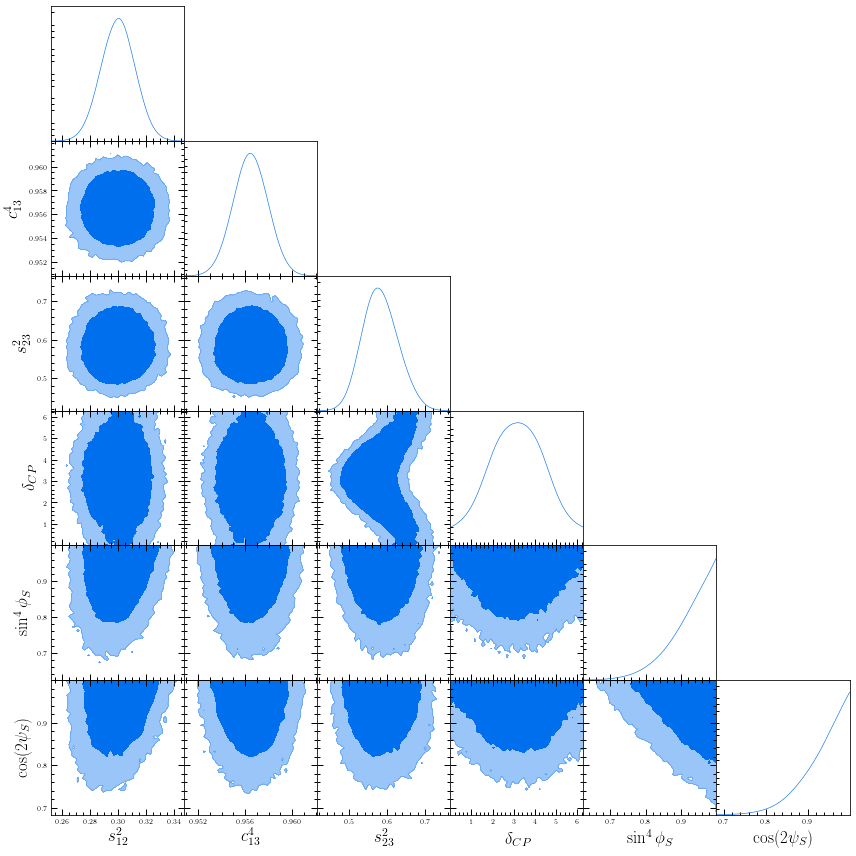

In [10]:
import golemflavor.plot as plot_utils
# getdist package requires `%matplotlib inline` to come after the import for inline notebook figures.
%matplotlib inline

plot_utils.plot_Tchain(samples, llh_paramset.labels, llh_paramset.ranges, llh_paramset.names)
plt.show()

Here, the non-diagonal plots show joint distributions between two parameters, labelled on the x- and y-axis and the diagonal plots show the marginalised distributions for each parameter, as labelled on the x-axis. The blue (light blue) shows the 90% (99%) credibility intervals.

As we did in the previous example, we can also see how this looks in a ternary plot.

In [11]:
source_angles = samples[:,-2:]
source_compositions = np.array(
    list(map(angles_to_fr, source_angles))
)

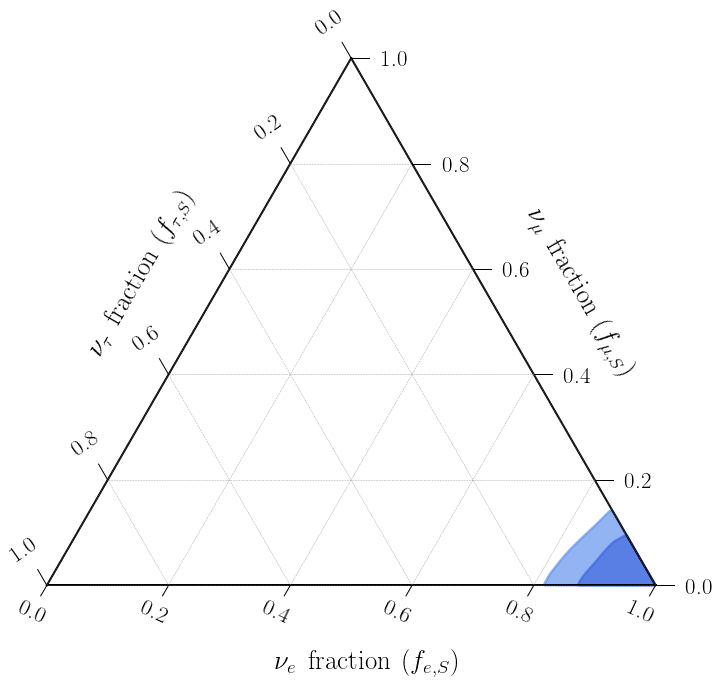

In [12]:
nbins = 25
fontsize = 23

# Figure
fig = plt.figure(figsize=(12, 12))

# Axis
ax = fig.add_subplot(111)
ax_labels = [
    r'$\nu_e\:\:{\rm fraction}\:\left( f_{e,S}\right)$',
    r'$\nu_\mu\:\:{\rm fraction}\:\left( f_{\mu,S}\right)$',
    r'$\nu_\tau\:\:{\rm fraction}\:\left( f_{\tau,S}\right)$'
]
tax = plot_utils.get_tax(ax, scale=nbins, ax_labels=ax_labels, rot_ax_labels=True)

# Plot source composition posteriors
coverages = [(99, 'cornflowerblue'), (90, 'royalblue')]
for cov, color in coverages:
    plot_utils.flavor_contour(
        frs=source_compositions,
        fill=True,
        ax=ax,
        nbins=nbins,
        coverage=cov,
        linewidth=2.5,
        color=color,
        alpha=0.7,
        oversample=5
    )

plt.show()

Great! Looks like our inference of the source flavor composition reflects the injected value $(1:0:0)_S$. Here, the credbility regions include the effect of smearing as well as our uncertainity about the values of the mixing matrix, which is why the values are not exactly at the injected $(1:0:0)_S$ value.

In a real analysis, an ensemble of nuisance parameters is usually required, related to uncertainties arising from things such as the astrophysical flux, detector calibration and backgrounds from atmospherically produced neutrinos. All these effects come into play when making inferences and careful analysis must be done for each in order to minimize potential biases.